In [1]:
# Build the Retrieval QA Chain with proper citations
# Read Resource 1. <How to get your RAG application to return sources?> (https://python.langchain.com/docs/how_to/qa_sources/)


# 1. use LangSmith
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [2]:
# Configure environment to connect to LangSmith.
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="KI_multi-modal-RAG"

In [3]:
# 4. Components
# 4.1 Select chat model: Google Gemini

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")


In [4]:
# 4.2 Select embedding model: HuggingFace
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [5]:
# 4.3 Select vector store: Chroma (install and upgrade langchain_chroma)
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [6]:
# RAG application: reconstruct the Q&A app with sources
# 1. index our documents:

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load PDF files from a folder
import os
folder_path = r"D:\4-IntoCode\16_LangChain\AgilProjekt_multiModel\Raw_Data\Apple"  # company folder, Use raw string
all_docs = []

for file in os.listdir(folder_path):
    if file.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(folder_path, file))
        pages = loader.load_and_split()
        all_docs.extend(pages)

# Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = splitter.split_documents(all_docs)
print(f"Loaded {len(docs)} chunks from {len(all_docs)} pages across {len(os.listdir(folder_path))} PDF files.")
# Result: "Loaded 4419 chunks from 1347 pages across 22 PDF files.


Loaded 4419 chunks from 1347 pages across 22 PDF files.


In [7]:
# Index chunks
_ = vector_store.add_documents(documents=docs)

In [47]:
# Build the application: generate an answer with list of sources.(von Artikel_1)
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# New part than RAG_App_Version_1(15.05)
from typing import List
from typing_extensions import Annotated, TypedDict


# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (author + year) used to answer the question",
    ]

# Define state for application (modified)
class State(TypedDict):
    question: str
    context: List[Document]
    answer: AnswerWithSources

# Define application steps 
def retrieve(state: State):  # (the Same)
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):    #(modified)
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    structured_llm = llm.with_structured_output(AnswerWithSources)
    response = structured_llm.invoke(messages)
    return {"answer": response.content}

# Compile application and test (the Same)
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

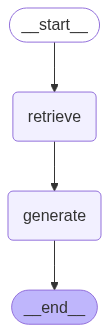

In [48]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import json

result = graph.invoke({"question": "What is Total net sales in 2020 in Apple Inc.?"}) # answer should be with Sources
print(json.dumps(result["answer"], indent=2))


In [51]:
# Conversational RAG: additional tool-calling features of chat models, a "back-and-forth" conversational user experience.
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [52]:
# build and compile the exact same application with 2 changes:
# 1. add a context key of the state to store retrieved documents;
# 2. In the generate step, we pluck out the retrieved documents and populate them in the state.
from langchain_core.messages import SystemMessage
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


class State(MessagesState):
    context: List[Document] # change 1


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    context = []
    for tool_message in tool_messages:                  # change 2
        context.extend(tool_message.artifact)
    return {"messages": [response], "context": context}

In [53]:
# compile the application as before:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

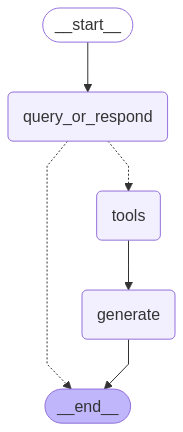

In [54]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
# Invoking our application, the retrieved Document objects are accessible from the application state.
input_message = "What is Total net sales in 2020 in Apple Inc.?" # ask the same question, the answer should be with ToolMessage

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Total net sales in 2020 in Apple Inc.?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b11a8ad7-c7cc-4585-b22f-1518b8b2b704)
 Call ID: b11a8ad7-c7cc-4585-b22f-1518b8b2b704
  Args:
    query: Total net sales in 2020 in Apple Inc.
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'anonymous', 'creationdate': '2022-10-27T16:05:06+00:00', 'creator': 'Workiva', 'moddate': '2022-10-27T16:05:06+00:00', 'page': 39, 'page_label': '40', 'producer': 'Wdesk Fidelity Content Translations Version 006.012.078', 'source': 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf', 'title': '10-K 2022, 09.24.2022-2022-10-27-08-59', 'total_pages': 80}
Content: 2022 2021 2020
iPhone (1) $ 205,489 $ 191,973 $ 137,781 
Mac (1)  40,177  35,190  28,622 
iPad (1)  29,292  

In [ ]:
# Results: "Total net sales in 2020 was $274,515" is correct. You can find this Info in 10-K-2022.pdf, page 40.
'''================================ Human Message =================================

What is Total net sales in 2020 in Apple Inc.?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b11a8ad7-c7cc-4585-b22f-1518b8b2b704)
 Call ID: b11a8ad7-c7cc-4585-b22f-1518b8b2b704
  Args:
    query: Total net sales in 2020 in Apple Inc.
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'anonymous', 'creationdate': '2022-10-27T16:05:06+00:00', 'creator': 'Workiva', 'moddate': '2022-10-27T16:05:06+00:00', 'page': 39, 'page_label': '40', 'producer': 'Wdesk Fidelity Content Translations Version 006.012.078', 'source': 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf', 'title': '10-K 2022, 09.24.2022-2022-10-27-08-59', 'total_pages': 80}
Content: 2022 2021 2020
iPhone (1) $ 205,489 $ 191,973 $ 137,781 
Mac (1)  40,177  35,190  28,622 
iPad (1)  29,292  31,862  23,724 
Wearables, Home and Accessories (1)(2)  41,241  38,367  30,620 
Services (3)  78,129  68,425  53,768 
Total net sales (4) $ 394,328 $ 365,817 $ 274,515 
(1) Products net sales include amortization of the deferred value of unspecified software upgrade rights, which are bundled in 
the sales price of the respective product.
(2) Wearables, Home and Accessories net sales include sales of AirPods, Apple TV, Apple Watch, Beats products, HomePod 
mini and accessories.
(3) Services net sales include sales from the Company’s advertising, AppleCare, cloud, digital content, payment and other 
...
(4) Includes $7.5 billion of revenue recognized in 2022 that was included in deferred revenue as of September 25, 2021, $6.7
================================== Ai Message ==================================

Total net sales in 2020 in Apple Inc. were $274,515. This number is listed in the provided document.'''


In [60]:
step["context"]

[Document(id='5266b8c1-a6c1-468f-8a95-ddd18341c7eb', metadata={'author': 'anonymous', 'creationdate': '2022-10-27T16:05:06+00:00', 'creator': 'Workiva', 'moddate': '2022-10-27T16:05:06+00:00', 'page': 39, 'page_label': '40', 'producer': 'Wdesk Fidelity Content Translations Version 006.012.078', 'source': 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf', 'title': '10-K 2022, 09.24.2022-2022-10-27-08-59', 'total_pages': 80}, page_content='2022 2021 2020\niPhone (1) $ 205,489 $ 191,973 $ 137,781 \nMac (1)  40,177  35,190  28,622 \niPad (1)  29,292  31,862  23,724 \nWearables, Home and Accessories (1)(2)  41,241  38,367  30,620 \nServices (3)  78,129  68,425  53,768 \nTotal net sales (4) $ 394,328 $ 365,817 $ 274,515 \n(1) Products net sales include amortization of the deferred value of unspecified software upgrade rights, which are bundled in \nthe sales price of the respective product.\n(2) Wearables, Home and Accessories net sales include sales of A

In [ ]:
# Read Resource 2. <How to get a RAG application to add citations?> (https://python.langchain.com/docs/how_to/qa_citations/)
# get a model to cite which parts of the source documents it referenced in generating its response.
# Method: Using tool-calling to cite document IDs;
# In the article, the author uses WikipediaRetriever, but we can use our own vector store.


In [93]:
# load a retriever and construct our prompt:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You're a helpful AI assistant. Given a user question "
    "and some PDF article snippets, answer the user "
    "question. If none of the articles answer the question, "
    "just say you don't know."
    "\n\nHere are the PDF articles: "
    "{context}"
)

retriever=vector_store.as_retriever() # use our own vector store
retriever.search_kwargs["k"] = 4  # number of documents to retrieve

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)
prompt.pretty_print()

================================ System Message ================================

You're a helpful AI assistant. Given a user question and some PDF article snippets, answer the user question. If none of the articles answer the question, just say you don't know.

Here are the PDF articles: {context}

================================ Human Message =================================

{question}


In [94]:
# adding citations to a RAG application
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [95]:
result = graph.invoke({"question": "What is Total net sales in 2020 in Apple Inc.?"})

sources = [doc.metadata["source"] for doc in result["context"]]
print(f"Sources: {sources}\n\n")
print(f'Answer: {result["answer"]}')

Sources: ['D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf']


Answer: Total net sales in 2020 for Apple Inc. was $274,515.


In [ ]:
# Result::
'''Sources: ['D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf']


Answer: Total net sales in 2020 for Apple Inc. was $274,515.'''

In [96]:
def format_docs_with_id(docs: List[Document]) -> str:
    formatted = [
        f"Source ID: {i}\nArticle Title: {doc.metadata['title']}\nArticle Snippet: {doc.page_content}"
        for i, doc in enumerate(docs)
    ]
    return "\n\n" + "\n\n".join(formatted)


class State(TypedDict):
    question: str
    context: List[Document]
    answer: CitedAnswer


def generate(state: State):
    formatted_docs = format_docs_with_id(state["context"])
    messages = prompt.invoke({"question": state["question"], "context": formatted_docs})
    structured_llm = llm.with_structured_output(CitedAnswer)
    response = structured_llm.invoke(messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [97]:
result = graph.invoke({"question": "What is Total net sales in 2020 in Apple Inc.?"})

result["answer"]

CitedAnswer(answer='Total net sales in 2020 in Apple Inc. is $ 274,515.', citations=[3])

In [ ]:
# Result:
'''CitedAnswer(answer='Total net sales in 2020 in Apple Inc. is $ 274,515.', citations=[3])'''

In [99]:
print(result["context"][3])

page_content='2022 2021 2020
iPhone (1) $ 205,489 $ 191,973 $ 137,781 
Mac (1)  40,177  35,190  28,622 
iPad (1)  29,292  31,862  23,724 
Wearables, Home and Accessories (1)(2)  41,241  38,367  30,620 
Services (3)  78,129  68,425  53,768 
Total net sales (4) $ 394,328 $ 365,817 $ 274,515 
(1) Products net sales include amortization of the deferred value of unspecified software upgrade rights, which are bundled in 
the sales price of the respective product.
(2) Wearables, Home and Accessories net sales include sales of AirPods, Apple TV, Apple Watch, Beats products, HomePod 
mini and accessories.
(3) Services net sales include sales from the Company’s advertising, AppleCare, cloud, digital content, payment and other 
services. Services net sales also include amortization of the deferred value of services bundled in the sales price of certain 
products.
(4) Includes $7.5 billion of revenue recognized in 2022 that was included in deferred revenue as of September 25, 2021, $6.7' metadata=